## Feature Importance Analysis

Analiza ważności cech to technika służąca do oceny, które zmienne wejściowe mają największy wpływ na predykcje modelu. Dzięki niej można zrozumieć, jak model podejmuje decyzje oraz które dane są dla niego najistotniejsze. Służy to raczej do interpretacji modeli niż do poprawiania wydajności, np. często jest wykorzystana w dziedzinie XAI (Explainable Artificial Intelligence)

In [1]:
import pandas as pd

train_cleaned = pd.read_csv('data/train_cleaned.csv')
val_cleaned   = pd.read_csv('data/val_cleaned.csv')

X_train = train_cleaned.iloc[:, :-1]
y_train = train_cleaned.iloc[:, -1]

X_val = val_cleaned.iloc[:, :-1]
y_val = val_cleaned.iloc[:, -1]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled  = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

Do przeprowadzania analizy ważności wykorzystam model lasu losowego, ponieważ ten model (podobnie do innych, opartych na drzewach decyzyjnych) automatycznie dostarcza informację o ważności cech, bazując na tym, jak często i jak bardzo dana cecha poprawia podział w drzewie.

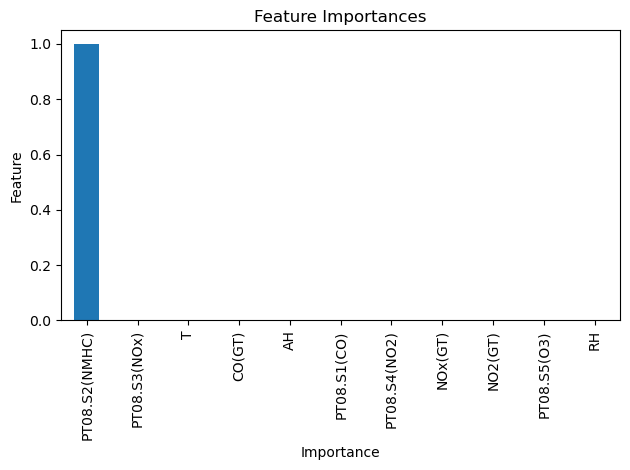

RMSE: 0.1628
MAE: 0.0201
R2: 0.9995


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def feature_improtances(X_train, y_train, X_val, y_val):
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    feature_importances = rf.feature_importances_
    feature_names = X_train.columns

    importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

    importances_df = importances_df.sort_values(by='Importance', ascending=False)

    importances_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    print(f'RMSE: {round(np.sqrt(mse), 4)}')
    print(f'MAE: {round(mae, 4)}')
    print(f'R2: {round(r2, 4)}')

feature_improtances(X_train_scaled, y_train, X_val_scaled, y_val)

Trenując ten sam model Random Forest co powyżej na tych samych danych (metryki o tym świadczą) widać, że tylko jedna zmienna ma wpływ na decyzję modelu. To jest totalna domiancja (100% wpływu) w porównaniu do pozostalych. Nie jest to żadnym błędem w budowaniu modelu, odwdrotnie nawet widać, że wynik predykcji jest bardzo dobry. Jeżeli powrócic do wizualizacji, czy chociażby selekcji cech to można zobaczyć, że własnie cecha `PT08.S2(NMHC)` najsilniej jest skorelowana ze zmienną objaśnianą (wsp.korelacji Pearsona 0.98). Jednak, w celu tej części projektu możemy usunąć tą cechą, aby zobaczyć jak zmieni się wydajność modelu oraz jego interpretacja

In [3]:
X_train_fi = X_train_scaled.drop(["PT08.S2(NMHC)"], axis = 1)
X_val_fi = X_val_scaled.drop(["PT08.S2(NMHC)"], axis = 1)

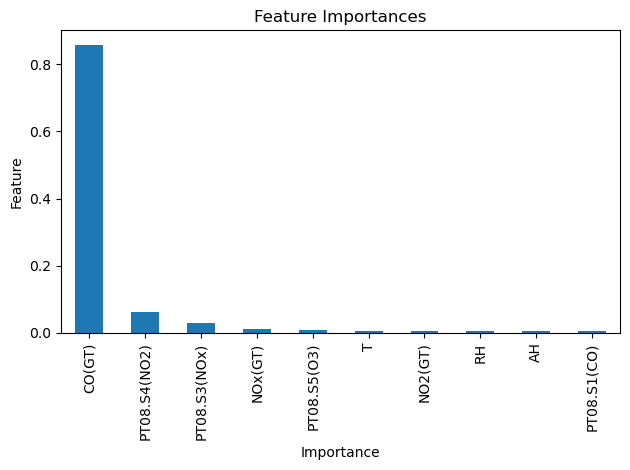

RMSE: 1.4297
MAE: 0.8204
R2: 0.9651


In [4]:
feature_improtances(X_train_fi, y_train, X_val_fi, y_val)

Po usunięciu `PT08.S2(NMHC)` jakość predykcji pogorszyła się, o czym świadczą wszystkie metryki. RMSE oraz MAE są większe niż w modelu bazowym, a $R^2$ mniejsze. Natomiast, sytuacja z ważnością cech poprawiła się, choć nie dużo. Zmienna `CO(GT)` teraz mocno dominuje nad pozostalymi (powyżej 80% wpływu), ale pozostale zmienne też wnoszą swój wkład w decyzję, choć niewielki. Spróbujemy zrobić analizę ważności ostatni raz, usuwając tym razem `CO(GT)`.

In [5]:
X_train_fi.drop(["CO(GT)"], axis = 1, inplace = True)
X_val_fi.drop(["CO(GT)"], axis = 1, inplace = True)

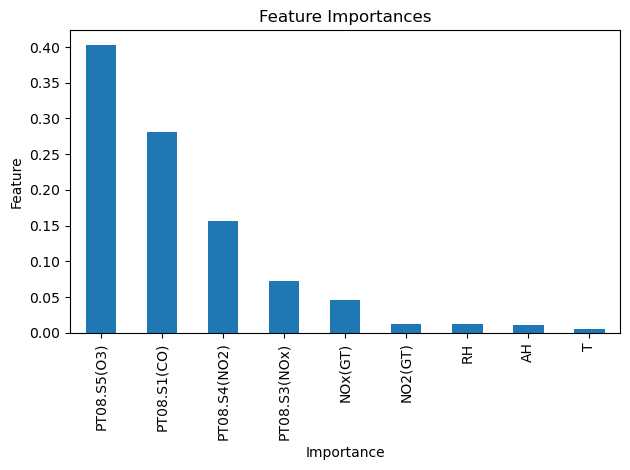

RMSE: 1.4453
MAE: 0.8142
R2: 0.9644


In [6]:
feature_improtances(X_train_fi, y_train, X_val_fi, y_val)

Ponieważ tracimy dodatkową ważną informację dla modelu (całą cechę), wydajność modelu spada. Predykcje oraz wyjasnienie wariancji zmiennej objaśnianej przez zmienne objasniające pogorszyły się, choć niewiele. Jednak, wykres z wpływem cech zmienił się w lepszą stronę. Po usunięciu zmiennej, która dominowała nad pozostalymi wpływ na decyzję stał bardziej rozproszony pomiędzy pozostalymi cechami. Teraz np. cechy `PT08.S5(O3)`, `PT08.S1(CO)` oraz `PT08.S4(NO2)` rodzieliły między sobą wpływ na decyzję (40%, 27%, 15% odpowiednio). Kosztem jakości predykcji zbudowaliśmy bardziej interpretowalny model, który odpowiedziłby na pytanie: "Jakie cechy najwięcej wpływają na na predkycje wartości benzenu?". Jednak nie będziemy używać takiego modelu do tuningu, ponieważ nie jest to głównym celem projektu.

## Hyperparameter tuning

Tuning hyperparametrów polega na znalezeniu optymalnych wartości, który są ustawione przed trenowaniem analitykiem/inżynierem i w żaden sposób nie są zmieniany czy optymalizowane pod czas trenowania modelu. Istnieje dwie najpopularniejsze metody poszukiwania takich wartości:
- Grid Search
- Random Search

Z nazw metod wynika w jaki sposób działają i może dla kogoś wydać się śmieszna druga metoda, bo "jak można losowo wybierając parametry znaleźć najlepszy". Jednak, metoda ta jest bardzo wygodna pod czas tuningu złożonych modeli (np. sieci neuronowych), bo trenowanie jednego bazowego modelu może trwać długo, a metoda siatki parametrów (czyli sprawdzanie każdej kombinacji) wydłuża ten czas kilka lub kilkadziesiąt razy. Metoda random search natomiast już kilka lat jest często używana i wiele razy udowodniła swoją przewagę nad Grid Search.

W naszym przypadku robimy tuning modelu `Random Forest`, który został wybrany wcześniej. Ponieważ trenowania bazowego modelu nie zajmuje dużo czasu, wykorzystamy Grid Search, polegającym na utworzeniu siatki parametrów ze wszystkimi kombinacjami 

#### Optymalizacja Random Forest

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 300, 500],          # liczba drzew w lesie
    'max_depth': [None, 10, 20],           # maksymalna głębokość drzewa
    'min_samples_split': [2, 5],               # minimalna liczba próbek do podziału węzła
    'min_samples_leaf': [1, 2],                 # minimalna liczba próbek w liściu
    'max_features': ['sqrt', 'log2', 1.0],
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    param_grid=param_grid,
    estimator=rf,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

grid_search.fit(X_train_scaled, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val_scaled)

mse = mean_squared_error(y_val, y_pred)
print("Najlepsze parametry:", grid_search.best_params_)
print("RMSE na zbiorze walidacyjnym:", np.sqrt(mse))
print("RMSE na zbiorze treningowym:", np.sqrt(mean_squared_error(y_train, best_model.predict(X_train_scaled))))

Najlepsze parametry: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
RMSE na zbiorze walidacyjnym: 0.08623124179471915
RMSE na zbiorze treningowym: 0.11464284210695994


Poprzez optymalizację parametrów modelu otrzymaliśmy lepszą predykcję modelu (mniejszy RMSE niż 0.1628 w modelu bazowym). RMSE na zbiorze treningowy stał większy (0.0649 w bazowym), jednak nie jest to żaden problem, nawet odwrotnie taki wynik oznacza mniejsze przeuczenie modelu na zbiorze treningowy ponieważ róznica pomiędzy RMSE walidacyjnym oraz RMSE treningowym zminejszyła sie.

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

poly_pipeline = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3, include_bias=False)),
    ("linear_regression", LinearRegression())
])

poly_pipeline.fit(X_train_scaled, y_train)
y_pred = poly_pipeline.predict(X_val_scaled)
mse = mean_squared_error(y_val, y_pred)

print("RMSE na zbiorze treningowym:", round(np.sqrt(mean_squared_error(y_train, poly_pipeline.predict(X_train_scaled))),4))

best_model = poly_pipeline

print("\nRMSE na zbiorze walidacyjnym:", round(np.sqrt(mse),4))
print("MAE na zbiorze walidacyjnym:", round(mean_absolute_error(y_val, y_pred),4))
print("R2 na zbiorze walidacyjnym:", round(r2_score(y_val, y_pred),4))

RMSE na zbiorze treningowym: 0.0291

RMSE na zbiorze walidacyjnym: 0.0312
MAE na zbiorze walidacyjnym: 0.0267
R2 na zbiorze walidacyjnym: 1.0


Mimo tego że udało się uzyskać lepsze wyniki dla modelu `Random Forest`, model `Polynomial Regression` jest nadal najlepszym modelem według RMSE zarówno na zbiorze walidacyjnym oraz treningowym (0.0312 oraz 0.0291 odpowiednio).

## Ewaluacja najlepszego modelu na zbiorze testowym

Po wszystkich iteracjach i zmianach w danych lub modelach, można testować najlepszy uzyskany model na zbiorze testowym. Ani model, ani my żadnego razu nie wykorzystaliśmy ten zbiór do modelowania, dlatego jakość predykcji na tym zbiorze pokaże jak model poradzi sobie z nowymi danymi.

In [42]:
test_cleaned = pd.read_csv('data/test_cleaned.csv')

X_test = test_cleaned.iloc[:, :-1]
y_test = test_cleaned.iloc[:, -1]

X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
y_pred = best_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE na zbiorze testowym:", round(np.sqrt(mse),4))
print("MAE na zbiorze testowym:", round(mae,4))
print("R2 na zbiorze testowym:", round(r2,4))

RMSE na zbiorze testowym: 0.0319
MAE na zbiorze testowym: 0.027
R2 na zbiorze testowym: 1.0


Porównując uzyskane wyniki z wynikami predykcji na zbiorze walidacyjnymi, możemy zrobić wniosek, że model nie jest przeuczony ani na zbiorze treningowym ani na walidacyjnym. Wartości metryk są podobne dla wszystkich zbiorów.

In [51]:
target = pd.concat([y_train, y_val, y_test], axis=0)
target.describe()

count    8991.000000
mean       10.083105
std         7.449820
min         0.100000
25%         4.400000
50%         8.200000
75%        14.000000
max        63.700000
Name: C6H6(GT), dtype: float64

Ponieważ wartości zmiennej objaśnianej `C6H6(GT)` są w przedziale od 0.1 do 63.7 ze średnią 10.08 oraz odchyleniem standardowym 7.45, wartość RMSE (czyli przeliczonym już na jednostki Y) na zbiorze testowym jest bardzo niska - 0.0319. To oznacza, że zbudowaliśmy model, który może bardzo dokładnie określić wartość benzenu w powietrzu na podstawie wartości pozostalych elementów.

## Eksport modelu

In [52]:
import joblib

joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

## Podsumowanie projektu

### 1. Wstępna eksploracja i wizualizacja danych

* *Wstępna eksploracja*
  * *Statystyki opisowe*

  * Obliczyliśmy podstawowe statystyki (średnia, mediana, odchylenie standardowe, min/max, kwartyle) dla każdej zmiennej.

* *Wizualizacje*

  * Zwizualizowaliśmy rozkłady wszystkich zmiennych oraz zależności pomiędzy nimi, by zidentyfikować ewentualne anomalia i zrozumieć kształt danych.



### 2. Czyszczenie i weryfikacja danych

1. *Sprawdzanie typów danych*

   * Zweryfikowaliśmy, że wszystkie kolumny pomiarowe są typu numerycznego.

2. *Usunięcie kolumn daty i czasu*

   * Kolumny Date i Time zostały odrzucone, ponieważ analizujemy dane w ujęciu godzinowym bez uwzględniania sezonowości czasowej na tym etapie.

3. *Usuwanie zduplikowanych wierszy*

   * Wykryliśmy i usunęliśmy duplikaty, aby uniknąć sztucznego zwiększenia liczebności próby.
4. *Podział na zbiory*

   * Dane podzielono w proporcji (np. 80% trening, 10% walidacja, 10% test), z zachowaniem losowości i unikaniem wycieku informacji (data leakage).
5. *Wartości brakujące*

   * Wykonaliśmy dokładną analizę wartości brakujących oraz zastosowaliśmy metodę KNN to wypełnienia niektórych
6. *Wartości odstające*

   * Chociaż zidentyfikowaliśmy obserwacje odstające, zdecydowaliśmy się ich nie usuwać, by nie tracić potencjalnych sygnałów środowiskowych.
7. *PCA*
    * Wykonaliśmy PCA na danych, by zmniejszyć wymiarowość danych, lecz zdecydowaliśmy się nie korzystać z wyników, ponieważ PCA nie przyniosła istotnych korzyści w tym przypadku.

### 3. Selekcja cech i finalny zbiór

* Na podstawie analizy korelacji oraz oceny znaczenia operacyjnego odrzucono zmienną:

  * NMHC(GT)
* Ostateczny zestaw cech wejściowych do modelowania:

  
  CO(GT), PT08.S1(CO), PT08.S2(NMHC),
  NOx(GT), PT08.S3(NOx), NO2(GT),
  PT08.S4(NO2), PT08.S5(O3),
  T, RH, AH
  
* Zmienna docelowa: C6H6(GT)

### 4. Standaryzacja cech

* Wszystkie cechy wejściowe zostały przekształcone do postaci standaryzowanej (średnia = 0, odchylenie = 1), aby wyrównać ich zakresy i jednostki.

### 5. Klasteryzacja jakości powietrza

* *Przeprowadziliśmy analizę klastrową za pomocą algorytmu K-średnich*

* *Wykonaliśmy podział na 3 klasy*
  Dzięki algorytmowi klasteryzacji udało się wyodrębnić trzy naturalne grupy obserwacji:

  1. *Klasa 0 (czerwony)* – zła jakość powietrza (powietrze zanieczyszczone).
  2. *Klasa 1 (niebieski)* – dobra jakość powietrza (niski poziom zanieczyszczenia).
  3. *Klasa 2 (zielony)* – jakość średnia (poziom umiarkowany).

* *Liczebność klastrów*

  * Klasa 1: ponad 3 500 obserwacji
  * Klasa 2: około 3 200 obserwacji
  * Klasa 0: około 2 100 obserwacji

* *Rozkład pozostałych cech w klastrach*
  Przyjrzenie się wykresom rozkładu kilku zmiennych (CO(GT), C6H6(GT), NOx(GT), NO2(GT)) w podziale na klastry potwierdziło:
  - Dla *Klasy 0* wartości wszystkich cech są najwyższe (zarówno mediana, jak i zakres).

  * *Klasy 1 i 2* mają wartości zbliżone do siebie; w przypadku zmiennych NOx i NO2 różnice między nimi są wręcz minimalne.

To uzupełnienie podkreśla, że dane dają się klarownie podzielić na trzy grupy odpowiadające zróżnicowanej jakości powietrza, co może być podstawą np. do segmentacji obszarów czy prognozowania poziomów zagrożeń.


### 6. Modele regresyjne

Przygotowaliśmy i porównaliśmy wstępne wersje następujących algorytmów:

* *Random Forest Regressor*
* *XGBoost Regressor*
* *CatBoost Regressor*
* *Decision Tree Regressor*
* *Linear Regression*
* *Polynomial Regression*
* *Lasso Regression*
* *Ridge Regression*

Każdy model był trenowany na zbiorze treningowym, bez optymalizacji hiperparametrów na zbiorze walidacyjnym, a ocena wykonana na zbiorze walidacyjnym przy użyciu metryk RMSE, MAE i $R^2$.

*Podsumowanie wyboru modeli*

* *Główne kryterium*: minimalizacja RMSE na zbiorze walidacyjnym.

Wybieramy *Polynomial Regression (deg=3)* oraz *Random Forest* jako modele do dalszej analizy, ponieważ:

| *Model*            | *RMSE Train* | *MAE Train* | *R² Train* | *RMSE Val* | *MAE Val* | *R² Val* | *Overfitting**| **Underfitting* |
| ----------------- | ---------- | --------- | -------- | -------- | ------- | ------ | ------------------- | ------------ |
| *Polynomial Regression (deg=3)*    | *0.0291*     | *0.0245*    | *1.0000*  | *0.0312*   | *0.0267*  | *1.0000* | *0.0021*  | *0.0000*  |
| *Random Forest*     | *0.0649*     | *0.0057*    | *0.9999*   | *0.1628*   | *0.0201*  | *0.9995* | *0.0979*              | *0.0000*    |

* *Polynomial Regression (deg=3)*
   - Osiąga *najniższy RMSE Val* (0.0312) oraz *najwyższy R² Val* (1.0000) na zbiorze testowym i trenigowym.
   - Nie wykazuje znaczącego nadmiaru lub braku dopasowującego się do danych.
   - Nie posiada hiperparametrów do dalszej walidacji modelu.

*  *Random Forest*
   - Zachowuje *wysoką dokładność* (R² Val = 0.9995),
   - *Małe RMSE Val* (0.1628) oraz *MAE Val* (0.0201) na zbiorze testowym.
   - Minimalizuje ryzyko *overfittingu*,  
   - Gwarantuje *odpowiednią generalizację*.
   - Posiada *hiperparametry* do dalszej walidacji modelu.

### 7. Analiza ważności 
* Przeprowadziliśmy analizę ważności w celu interpretacji uzyskanego modelu oraz oceny wpływu predyktorów na predykcję
* Porównaliśmy kilka modeli (po usuwaniu wybranych zmiennych) w celu zlikwidowania dominacji wpływu jednej zmiennej

### 8. Optymalizacja hiperparametrów
* Wykonaliśmy tuning hiperparametrów modelu *Random Forest* w celu poprawy jakości predykcji 
* Znalezliśmy odpowiednie parametry za pomocą metody *Grid Search*, jednak wybraliśmy model *Polynomial Regression* jako ostateczny

### 9. Ewaluacja modelu na danych testowych
* Dokonaliśmy predykcję za pomocą najlepszego modelu na danych ze zbioru testowego w celu unikania przeuczenia pod czas iterowanego poprawiania metod przetwarzania danych lub optymalizacji hiperparametrów modelu
* Porównaliśmy wartości wybranych metryk (RMSE, MAE, $R^2$) z rozkładem zmiennej objaśnianej

### 10. Eksport modelu
* Wyeksportowaliśmy model jako plik .pkl, aby móc go ponownie wykorzystać – np. w aplikacji internetowej jako część back-endu – bez potrzeby ponownego trenowania.